# Overlappogram Simulation Workflow

Demo workflow for producing a simulated overlappogram. 

1. Compute DEM from AIA+XRT data
2. Compute spectral table as function of $\lambda$ and $T_e$ from CHIANTI
3. Compute spectral cube by taking outer product of DEM and spectral table
4. Compute instrument intensities by convolving 
5. Reproject to detector geometry

In [1]:
import sys
import glob
import copy

import numpy as np
#import jax
#import jax.scipy
#import cupy
#import cupyx.scipy
from scipy.interpolate import interp1d
import astropy.units as u
import astropy.time
import astropy.wcs
import astropy.io.fits
from astropy.coordinates import SkyCoord
import astropy.constants
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker
from sunpy.map import Map, make_fitswcs_header
from sunpy.net import Fido, attrs as a
from sunpy.net.attr import and_,or_
from sunpy.time import TimeRange
from sunpy.coordinates import Helioprojective
import sunpy.io
import sunpy.map.maputils
from ndcube import NDCube, NDCollection
from astropy.nddata import StdDevUncertainty
from astropy.visualization import (ImageNormalize, LogStretch, SqrtStretch, AsinhStretch,
                                   PowerStretch, quantity_support, AsymmetricPercentileInterval)
from aiapy.calibrate import register, estimate_error, correct_degradation
from sunkit_dem import Model
from sunkit_dem.models import HK12Model
import reproject

import dask
import distributed
import dask.array
from dask.distributed import PipInstall
from dask_gateway import Gateway, GatewayCluster

from overlappy.reproject import reproject_to_overlappogram
from overlappy.wcs import pcij_matrix, overlappogram_fits_wcs
from overlappy.util import color_lat_lon_axes, strided_array
from overlappy.io import read_overlappogram, write_overlappogram

sys.path.append('physics/dem')
from dem_models import (get_aia_temperature_response,
                        get_xrt_temperature_response,
                        PlowmanModel)
sys.path.append('physics/spectral')
from spectral_utils import read_spectral_table
sys.path.append('detector')
from response import SpectrogramChannel, Channel

#%load_ext snakeviz

/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
# The following numbers are from Jake and Albert:
CDELT_SPACE = 5.66 * u.arcsec / u.pix
CDELT_WAVE = 55 * u.milliangstrom / u.pix
# This comes from the proposal:
DETECTOR_SHAPE_DISPERSED = (750, 2000)
DETECTOR_SHAPE_PINHOLE = (750, 475)

## Setup Dask Client

Useful for reprojection and DEM computation

In [10]:
gateway = Gateway()
options = gateway.cluster_options()
options.worker_cores=4
options.worker_memory=8

In [11]:
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster

In [5]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub.dafd0cd9b9ad4f868ff57b8ca75bdbdf/status,


In [12]:
pip_plugin = PipInstall(
    packages=["ndcube",
              "git+https://github.com/astropy/reproject.git@main",
              "git+https://github.com/wtbarnes/overlappy.git@main",
              "git+https://github.com/wtbarnes/sunkit-dem.git@ndcube-2.0-fixes"],
    pip_options=["--upgrade"],
)
client.register_worker_plugin(pip_plugin)

{'tls://192.168.1.51:32827': {'status': 'OK'}}

In [14]:
cluster.shutdown()

In [47]:
client.restart()

Exception: Tried sending message after closing.  Status: closed
Message: {'op': 'restart', 'timeout': 60}

## Get Data

In [ ]:
date = astropy.time.Time('2020-11-09 18:00:00') 
euv_wavelengths = or_(*[a.Wavelength(w) 
                        for w in [94,131,171,193,211,335]*u.angstrom])
q = Fido.search(a.Time(date, date+1*u.h, near=date),
                euv_wavelengths,
                a.Instrument.aia)

In [3]:
#files = Fido.fetch(q, path='../data/{instrument}')
files = sorted(glob.glob('data/AIA/*.fits'))

For now, I'm grabbing the Be-thin synoptic image from [here](http://solar.physics.montana.edu/HINODE/XRT/SCIA/synop_images/syncmp_FITS/2020/11/). Once the XRT data comes back online in the VSO, we'll just query it from there.

In [4]:
files += ['data/XRT/comp_XRT20201109_181902.6.fits']

## Build Data Cube

Reproject AIA and XRT images all into the same WCS and make estimates of the uncertainties.

In [5]:
cubes = []
ref_coordinate = SkyCoord(0,0,unit='arcsec', frame=Map(files[0]).coordinate_frame)
for f in files:
    m = Map(f)    
    # Construct new WCS to reproject to. This will resample and derotate each map to the same
    # frame
    new_header = make_fitswcs_header(
        (450,450),  # It doesn't really matter what this is as long as we include the full disk
        ref_coordinate,
        scale=u.Quantity([5, 5], 'arcsec / pix'),
        rotation_angle=0*u.deg,
        instrument=m.instrument,
        observatory=m.observatory,
        wavelength=m.wavelength,
        exposure=m.exposure_time,
        projection_code='TAN',
    )
    new_header['BUNIT'] = str(m.unit / u.pix if m.unit is not None else u.ct / u.pix)
    if 'EC_FW1_' in m.meta:
        new_header['EC_FW1_'] = m.meta['EC_FW1_']
    if 'EC_FW2_' in m.meta:
        new_header['EC_FW2_'] = m.meta['EC_FW2_']
    with Helioprojective.assume_spherical_screen(m.observer_coordinate, only_off_disk=True):
        _m = m.reproject_to(astropy.wcs.WCS(new_header), algorithm='adaptive')
    n_sample = int(np.round(m.dimensions.x / _m.dimensions.x))
    new_data = _m.data
    new_data[np.isnan(new_data)] = np.nanmin(new_data)
    m = Map(new_data, new_header)
    # REMOVE THIS BLOCK
    #blc = SkyCoord(Tx=-50*u.arcsec,Ty=-550*u.arcsec,frame=m.coordinate_frame)
    #m = m.submap(blc, width=200*u.arcsec, height=200*u.arcsec)
    # REMOVE THIS BLOCK
    # compute uncertainties
    if 'AIA' in m.instrument:
        m = correct_degradation(m,
                                correction_table='data/aia_V8_20171210_050627_response_table.txt',
                                calibration_version=8,)
        error = estimate_error(m.quantity, m.wavelength,
                               n_sample=n_sample,
                               error_table='data/aia_V3_error_table.txt')
    else:
        # For XRT, just assume 20% uncertainty
        error = m.quantity*0.2
    error[np.isnan(error)] = 0.0 * error.unit
    ### WARNING: REMOVE THIS IF WE GO BACK TO PLOWMAN OR CHEUNG DEM METHODS ###
    ### AS THEY ASSUME UNITS OF DN, not DN s-1 ################################
    error /= m.exposure_time
    m /= m.exposure_time
    ###########################################################################
    error = StdDevUncertainty(error)
    # Build cube
    cube = NDCube(m.quantity, wcs=m.wcs, uncertainty=error, meta=m.meta, )
    cubes.append((str(m.measurement), cube))
map_collection = NDCollection(cubes, aligned_axes=(0,1))

/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 9 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 9 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-p

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


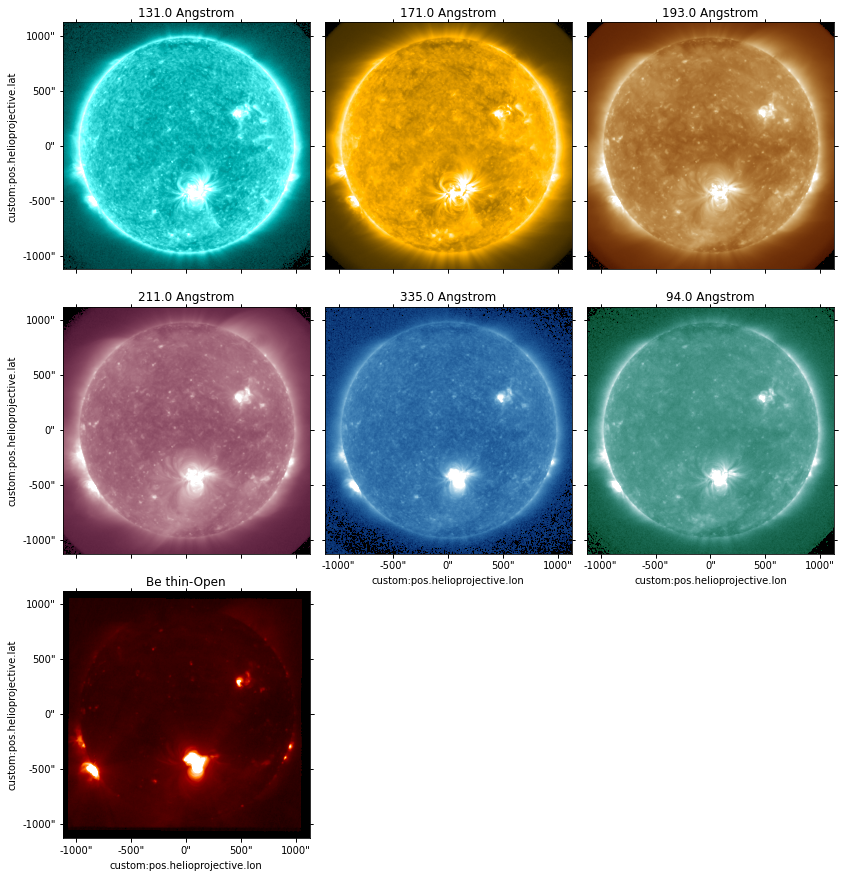

In [33]:
fig = plt.figure(figsize=(14,15))
for i,k in enumerate(map_collection):
    vmin,vmax = AsymmetricPercentileInterval(1,99.5).get_limits(map_collection[k].data)
    vmin = max(vmin,0)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=PowerStretch(0.3))
    ax = fig.add_subplot(3,3,i+1,projection=map_collection[k].wcs)
    cmap = f"sdoaia{int(map_collection[k].meta['wavelnth'])}" if 'AIA' in map_collection[k].meta['instrume'] else 'hinodexrt'
    map_collection[k].plot(axes=ax,norm=norm,cmap=cmap)
    ax.set_title(k)
    lon,lat = ax.coords
    if i%3 != 0:
        lat.set_axislabel(' ')
        lat.set_ticklabel_visible(False)
    if i <= 3:
        lon.set_axislabel(' ')
        lon.set_ticklabel_visible(False)
plt.subplots_adjust(hspace=0.15,wspace=0.02)
plt.savefig('output/aia-xrt-images.png',dpi=200)

## Response Functions

In [6]:
logt_bin_width = 0.1
logt = np.arange(5.7, 7.6, logt_bin_width)
temperature_bin_edges = 10**logt * u.K
temperature_bin_centers = 10**((logt[1:] + logt[:-1])/2) * u.K

In [7]:
aia_euv_channels = [94, 131, 171, 193, 211, 335] * u.angstrom
aia_responses = get_aia_temperature_response('data/aia_temperature_response.asdf', aia_euv_channels, temperature_bin_centers)
xrt_channels = ['Be_thin']
xrt_responses = get_xrt_temperature_response('data/xrt_temperature_response.asdf', xrt_channels, temperature_bin_centers,
                                             correction_factor=1)
all_responses = {**aia_responses, **xrt_responses}

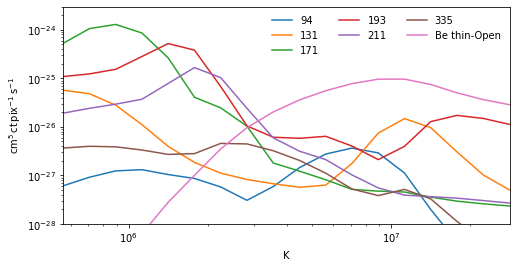

In [8]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
with quantity_support():
    for k in all_responses:
        ax.plot(temperature_bin_centers, all_responses[k],
                label=f'{float(k.split()[0]):.0f}' if 'Angstrom' in k else k)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(ncol=3,frameon=False)
ax.set_ylim(1e-28, 3e-24)
ax.set_xlim(temperature_bin_centers[[0,-1]])
fig.savefig('output/temperature-response.png',dpi=200)

## Invert

In [ ]:
simple_reg_model = Model(
    map_collection,
    {k: all_responses[k] for k in map_collection},
    temperature_bin_edges,
    model='plowman'
)

In [ ]:
sparse_model = Model(
    map_collection,
    {k: all_responses[k] for k in map_collection},
    temperature_bin_edges,
    model='cheung'
)

In [9]:
reg_model = Model(
    map_collection,
    {k: all_responses[k] for k in map_collection},
    temperature_bin_edges,
    model='hk12',
)

In [15]:
#dem = reg_model.fit(method=None)
dem = reg_model.fit(use_dask=False)

/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/sunkit_dem/models/hk12.py:411: RuntimeWarning: divide by zero encountered in true_divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/sunkit_dem/models/hk12.py:412: RuntimeWarning: divide by zero encountered in true_divide
  dn=dnin/ednin
/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/sunkit_dem/models/hk12.py:413: RuntimeWarning: invalid value encountered in true_divide
  edn=ednin/ednin


KeyboardInterrupt: 

In [ ]:
tbin_centers = dem['em'].axis_world_coords(0)[0]
norm = ImageNormalize(vmin=1e23,vmax=1e28,stretch=LogStretch())
fig = plt.figure(figsize=(20,20))
for i in range(int(dem['em'].dimensions[0].value)):
    ax = fig.add_subplot(5,5,i+1,projection=dem['dem'][i].wcs)
    dem['em'][i,...].plot(axes=ax, cmap='inferno', norm=norm)
    ax.set_title(f"{tbin_centers[i].to_value('MK'):0.2f}")
    if i%5 == 0:
        ax.coords[1].set_axislabel(' ')
    if i<15:
        ax.coords[0].set_axislabel(' ')

## Make Spectral Cube

In [166]:
spectral_tab = read_spectral_table('physics/spectral/spectral-table.asdf')

/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/format/utils.py:219: UnitsWarning: The unit 'Angstrom' has been deprecated in the VOUnit standard. Suggested: 0.1nm.
  warnings.warn(message, UnitsWarning)


/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/format/utils.py:219: UnitsWarning: The unit 'Angstrom' has been deprecated in the VOUnit standard. Suggested: 0.1nm.
  warnings.warn(message, UnitsWarning)
/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/format/utils.py:219: UnitsWarning: The unit 'Angstrom' has been deprecated in the VOUnit standard. Suggested: 0.1nm.
  warnings.warn(message, UnitsWarning)


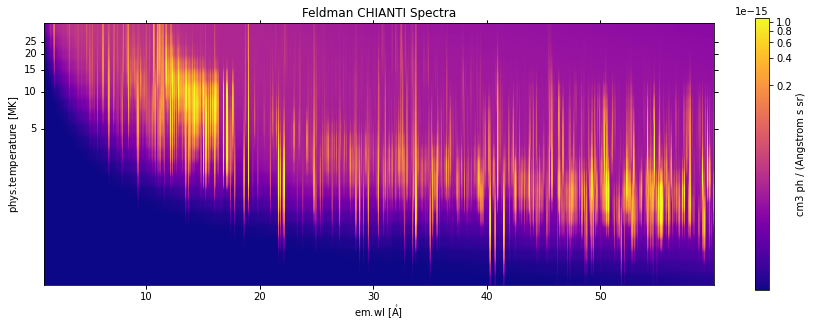

In [172]:
fig = plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(1,99.5).get_limits(spectral_tab.data)
spectral_tab.plot(aspect=20,
                  axes_units=('MK','Angstrom'),
                  norm=ImageNormalize(vmin=vmin,vmax=vmax,stretch=LogStretch()),
                  cmap='plasma')
plt.colorbar(label=spectral_tab.unit)
plt.title('Feldman CHIANTI Spectra')
plt.savefig('output/chianti-spectra.png',dpi=200)

Now, compute the spectral cube from the DEM and spectral table.

First, interpolate the spectral table to the temperatures of the DEM

In [ ]:
def calculate_spectral_cube(dem, spectra, celestial_wcs):
    """
    Convolve spectra with DEM to produce intensity cube
    
    Paramters
    ---------
    dem  : `~ndcube.NDCube`
        Array of DEM values, where the first dimension corresponds to the 
        temperature
    spectra : `~ndcube.NDCube`
        Array of spectra as a function of temperature and wavelength
    """
    # FIXME: should be able to extract the celestial WCS from the DEM WCS
    
    temperature_bin_centers = dem.axis_world_coords(0)[0]
    wavelength_spectra = spectra.axis_world_coords(1)[0]
    temperature_spectra = spectra.axis_world_coords(0)[0].to(temperature_bin_centers.unit)
    # Interpolate spectral table to DEM temperatures
    spectra_interp = interp1d(temperature_spectra.value, spectra.data, axis=0,)(temperature_bin_centers.value)
    # FIXME: Is this the right thing to do?
    # We should be doing the above interpolation such that there are no negative values
    # when interpolated
    spectra_interp[spectra_interp < 0] = 0.0
    # There may be NaNs from the inversion.
    # FIXME: in general, may be better to handle this before we get to this step
    # At the very least, raise a warning
    dem_data = np.where(np.isnan(dem.data), 0.0, dem.data)
    # FIXME: Is this the right thing to do? Why are these negative?
    # At the very least, raise a warning
    dem_data = np.where(dem_data < 0, 0.0, dem_data)
    # Convolve DEM and spectra
    # FIXME: replace this with np.tensordot: https://numpy.org/doc/stable/reference/generated/numpy.tensordot.html
    _intensity = np.zeros((dem_data.shape[1]*dem_data.shape[2],)+wavelength_spectra.shape)
    for i in range(temperature_bin_centers.shape[0]):
        _intensity += np.outer(dem_data[i,:,:], spectra_interp[i,:],)
    # Reshape data array appropriately
    intensity_unit = dem.unit * spectra.unit
    intensity = _intensity.T.reshape(spectra_interp.shape[1:] + dem.data.shape[1:]) * intensity_unit
    # Create celestial WCS based on the FOV and observer position
    # The choice of the first channel is arbitrary, it does not affect the resulting WCS
    new_wcs = add_spectral_wcs(celestial_wcs, wavelength_spectra)
    # Add intensity axis
    return NDCube(intensity, wcs=new_wcs, meta=spectra.meta)


def add_spectral_wcs(celestial_wcs, wavelength):
    wcs_header = celestial_wcs.to_header()
    # NOTE: this assumes that the wavelength dimension is linear
    wcs_header['CDELT3'] = np.diff(wavelength)[0].value
    wcs_header['CUNIT3'] = wavelength.unit.to_string()
    wcs_header['CRPIX3'] = 0
    wcs_header['CRVAL3'] = wavelength[0].value
    wcs_header['CTYPE3'] = 'WAVE'
    return astropy.wcs.WCS(header=wcs_header)

In [ ]:
spectral_cube = calculate_spectral_cube(dem['em'], spectral_tab, map_collection['171.0 Angstrom'].wcs)

In [ ]:
spectral_cube[900,...].plot(norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()

Save this result out here!!

In [ ]:
header = spectral_cube.wcs.to_header()
header['BUNIT'] = spectral_cube.unit.to_string()
sunpy.io._fits.write('spectral-cube-example.fits',
                     spectral_cube.data,
                     header,
                     hdu_type=CompImageHDU)

And read it back in

In [16]:
def read_cube(filename, hdu=0):
    with astropy.io.fits.open(filename) as hdul:
        data = hdul[hdu].data
        header = hdul[hdu].header
        header.pop('KEYCOMMENTS', None)
        wcs = astropy.wcs.WCS(header=header)
        spec_cube = NDCube(data, wcs=wcs, meta=header, unit=header.get('BUNIT', None))
    return spec_cube

In [17]:
spectral_cube = read_cube('spectral-cube-example.fits', hdu=1)

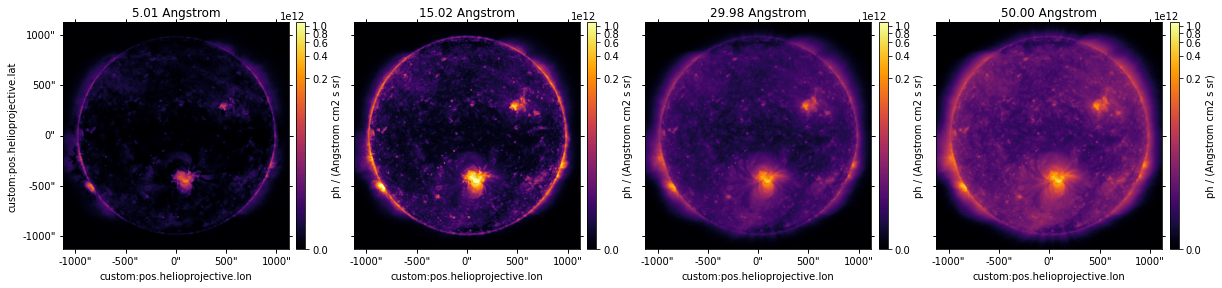

In [66]:
fig = plt.figure(figsize=(20,6))
for i,w in enumerate([5, 15, 30, 50] * u.angstrom):
    spec_slice = spectral_cube.crop([None,w],[None,w+0.01*u.angstrom])
    norm = ImageNormalize(vmin=0, vmax=1.1e12, stretch=LogStretch())
    ax = fig.add_subplot(1,4,i+1, projection=spec_slice.wcs)
    spec_slice.plot(cmap='inferno',norm=norm, axes=ax)
    im = ax.get_images()[0]
    ax.set_title(f"{spec_slice.global_coords['em.wl'].to('Angstrom'):.2f}")
    lon,lat = ax.coords
    if i != 0:
        lat.set_axislabel(' ')
        lat.set_ticklabel_visible(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.1, axes_class=matplotlib.axes.Axes)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cax.yaxis.set_ticks_position("right")
    cbar.set_label(spec_slice.unit)
#plt.subplots_adjust(wspace=0.1)
fig.savefig('output/spectral-slices.png',dpi=200)

## Convert to Instrument Units

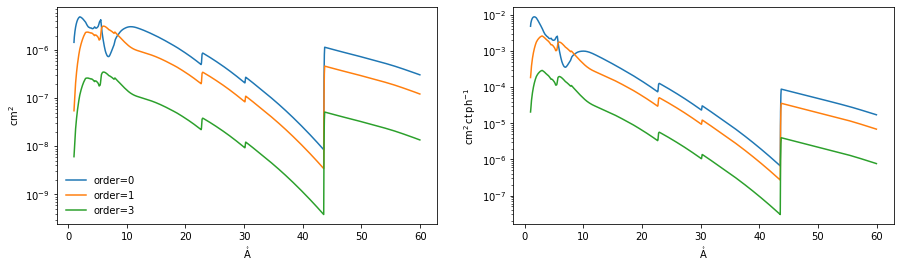

In [60]:
fig = plt.figure(figsize=(15,4))
with quantity_support():
    ax = fig.add_subplot(121)
    for order in [0,1,3]:
        chan = SpectrogramChannel(order, 'data/MOXSI_effarea.genx')
        ax.plot(chan.wavelength, chan.effective_area, label=f'order={order}')
    ax.set_yscale('log')
    ax.legend(frameon=False)
    ax = fig.add_subplot(122)
    for order in [0,1,3]:
        chan = SpectrogramChannel(order, 'data/MOXSI_effarea.genx')
        ax.plot(chan.wavelength, chan.wavelength_response)
    ax.set_yscale('log')
fig.savefig('output/effective-area-curves.png', dpi=200)

In [67]:
def convolve_with_response(cube, channel):
    """
    Convolve spectral cube with wavelength response to convert spectra to instrument units.
    
    Parameters
    ----------
    cube : `ndcube.NDCube`
    channel : `Channel`
    
    Return
    ------
    : `ndcube.NDCube`
        Spectral cube in detector units convolved with instrument response
    """
    # FIXME: this should go in the Channel object
    plate_scale = CDELT_SPACE * CDELT_SPACE * u.pix
    # Interpolate wavelength response to wavelength array of spectral cube
    # NOTE: should this be done in reverse?
    wavelength = cube.axis_world_coords(0)[0].to_value('Angstrom')
    f_response = interp1d(channel.wavelength.to_value('Angstrom'),
                          channel.wavelength_response.to_value(),
                          bounds_error=False,
                          fill_value=0.0,)  # Response is 0 outside of the response range
    response = u.Quantity(f_response(wavelength), channel.wavelength_response.unit)
    response *= plate_scale
    response *= CDELT_WAVE * u.pix
    
    # Multiply by spectral cube
    data = (cube.data.T * cube.unit * response).T 
    
    meta = copy.deepcopy(cube.meta)
    meta['channel_name'] = channel.name
    
    return NDCube(data.to('ct pix-1 s-1'), wcs=cube.wcs, meta=meta)

In [100]:
spec_cube_instr = convolve_with_response(spectral_cube, SpectrogramChannel(3, 'data/MOXSI_effarea.genx'))

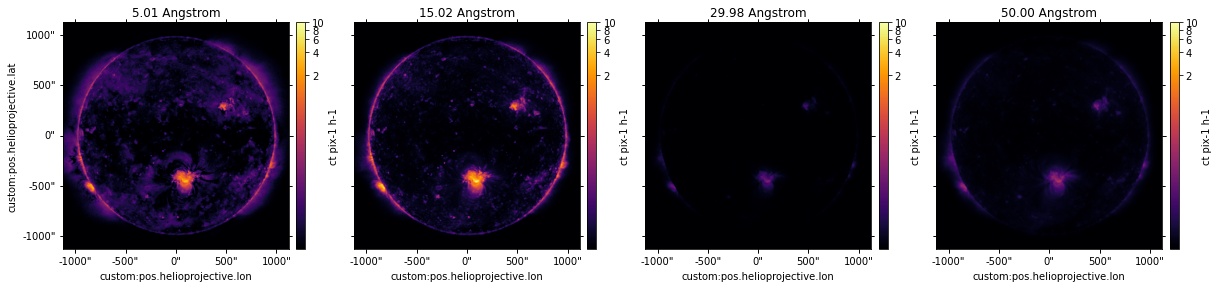

In [101]:
fig = plt.figure(figsize=(20,6))
for i,w in enumerate([5, 15, 30, 50] * u.angstrom):
    spec_slice = spec_cube_instr.crop([None,w],[None,w+0.01*u.angstrom])
    norm = ImageNormalize(vmax=10, vmin=5e-4,stretch=LogStretch())
    ax = fig.add_subplot(1,4,i+1, projection=spec_slice.wcs)
    plot_unit = 'ct pix-1 h-1'
    spec_slice.plot(cmap='inferno',norm=norm, axes=ax, data_unit=plot_unit)
    im = ax.get_images()[0]
    ax.set_title(f"{spec_slice.global_coords['em.wl'].to('Angstrom'):.2f}")
    lon,lat = ax.coords
    if i != 0:
        lat.set_axislabel(' ')
        lat.set_ticklabel_visible(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.1, axes_class=matplotlib.axes.Axes)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cax.yaxis.set_ticks_position("right")
    #cax.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterSciNotation())
    #cax.yaxis.set_major_locator(matplotlib.ticker.Locator())
    cbar.set_label(plot_unit)
#plt.subplots_adjust(wspace=0.1)
fig.savefig('output/spectral-slices-instr-order3.png',dpi=200)

## Reproject

Reproject the spectral cube to the dispersed image on the detector

TODO: fold this into the `reproject_to_overlappogram` function in `overlappy`.

In [8]:
def reproject_to_overlappogram_parallelized(cube,
                                            detector_shape,
                                            reference_pixel=None,
                                            reference_coord=None,
                                            scale=None,
                                            roll_angle=0*u.deg,
                                            dispersion_angle=0*u.deg,
                                            dispersion_axis=0,
                                            order=1,
                                            observer=None,
                                            sum_over_lambda=True,
                                            reproject_kwargs=None,
                                            meta_keys=None):
    
    wavelength = cube.axis_world_coords(0)[0].to('angstrom')
    pc_matrix = pcij_matrix(roll_angle, dispersion_angle,
                            order=order, dispersion_axis=dispersion_axis)
    if scale is None:
        scale = [u.Quantity(cd, f'{cu} / pix') for cd, cu in
                 zip(cube.wcs.wcs.cdelt, cube.wcs.wcs.cunit)]

    reproject_kwargs = {} if reproject_kwargs is None else reproject_kwargs
    
    # if you're using this approach, you must specify the reference
    # coord and reference pixel explicitly
    if reference_coord is None:
        raise ValueError('Must specify reference coord explicitly')
    if reference_pixel is None:
        raise ValueError('Must specify reference pixel explicitly')
    
    # Iterate over each slice, adjusting the reference pixel at each iteration
    # Making this a function to enable parallelism
    def _reproject_slice(cube_slice, wcs_slice, data_cube=None):
        return reproject.reproject_interp(
            cube_slice,
            wcs_slice,
            shape_out=wcs_slice.array_shape,
            return_footprint=False,
            #**repr_kwargs,
        ).squeeze()
    
    
    client = distributed.get_client()
    indices = list(range(cube.data.shape[0]))
    cube_slices = client.scatter([cube[i:i+1] for i in indices], direct=True)

    # Get all of the output WCSs
    print('Building WCS slice list')
    output_wcs_slices = []
    for i in indices:
        ref_pix = copy.deepcopy(reference_pixel)
        ref_pix[2] = (-i + 1) * u.pix
        output_wcs_slices.append(overlappogram_fits_wcs(
            detector_shape,
            wavelength[i:i+1],
            scale,
            reference_pixel=ref_pix,
            reference_coord=reference_coord,
            pc_matrix=pc_matrix,
            observer=observer,
        ))
    
    slice_futures = client.map(
        _reproject_slice,
        cube_slices,
        output_wcs_slices,
        #repr_kwargs=reproject_kwargs,
        pure=True,
    )
    
    # distributed.wait(slice_futures)
    # for i,f in enumerate(slice_futures):
    #     fexc = f.exception()
    #     if fexc is not None:
    #         raise ValueError(f'{i}: {fexc}')
    
    overlap_data = dask.array.stack([
        dask.array.from_delayed(f, detector_shape, dtype=cube.data.dtype)
        for f in slice_futures
    ])
    
    if sum_over_lambda:
        overlap_data = np.where(np.isnan(overlap_data), 0.0, overlap_data)
        overlap_data = overlap_data.sum(axis=0)
        # Put this in an if block for our more general implementation
        # Purposefully calling compute before constructing the strided
        # array because I'm not sure how a Dask array will play with the
        # strided tricks stuff in numpy
        overlap_data = overlap_data.compute()
        overlap_data = strided_array(overlap_data, wavelength.shape[0])

    meta = {}
    if meta_keys is not None:
        for k in meta_keys:
            meta[k] = cube.meta.get(k)
    
    # rebuild full wcs
    overlap_wcs = overlappogram_fits_wcs(
        detector_shape,
        wavelength,
        scale,
        reference_pixel=reference_pixel,
        reference_coord=reference_coord,
        pc_matrix=pc_matrix,
        observer=observer,
    )

    return NDCube(overlap_data, wcs=overlap_wcs, unit=cube.unit, meta=meta)

In [8]:
observer = astropy.wcs.utils.wcs_to_celestial_frame(spectral_cube.wcs).observer

And now finally apply this for all five orders

In [24]:
overlappograms = []
orders = [-3, -1, 0, 1, 3]
for order in orders:
    print(f'Computing order {order}')
    chan = SpectrogramChannel(order, 'data/MOXSI_effarea.genx')
    _spec_cube = convolve_with_response(spectral_cube, chan)
    _overlap = reproject_to_overlappogram_parallelized(
        _spec_cube[:100],
        DETECTOR_SHAPE_DISPERSED,
        scale=(CDELT_SPACE, CDELT_SPACE, CDELT_WAVE),
        reference_pixel=(
          (DETECTOR_SHAPE_DISPERSED[1] + 1)/2,
          (DETECTOR_SHAPE_DISPERSED[0] + 1)/2,
          1,
        ) * u.pix,
        reference_coord=(
            0 * u.arcsec,
            0 * u.arcsec,
            _spec_cube.axis_world_coords(0)[0][0],
        ),
        roll_angle=-90*u.deg,  # orient such that solar-N points along the +1 dispersed direction
        dispersion_angle=0*u.deg,
        order=order,
        observer=observer,
        sum_over_lambda=True,
    )
    overlappograms.append(_overlap)
    # Save out overlappogram to disk here

<WCSAxesSubplot:>

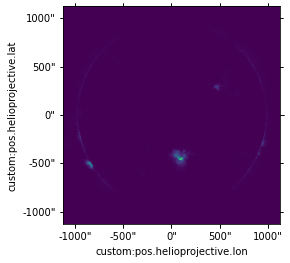

In [67]:
_spec_cube[100].plot()

In [24]:
order = 3
print(f'Computing order {order}')
chan = SpectrogramChannel(order, 'data/MOXSI_effarea.genx')
_spec_cube = convolve_with_response(spectral_cube, chan)
_overlap = reproject_to_overlappogram_parallelized(
    _spec_cube,
    DETECTOR_SHAPE_DISPERSED,
    scale=(CDELT_SPACE, CDELT_SPACE, CDELT_WAVE),
    reference_pixel=(
      (DETECTOR_SHAPE_DISPERSED[1] + 1)/2,
      (DETECTOR_SHAPE_DISPERSED[0] + 1)/2,
      1,
    ) * u.pix,
    reference_coord=(
        0 * u.arcsec,
        0 * u.arcsec,
        _spec_cube.axis_world_coords(0)[0][0],
    ),
    roll_angle=-90*u.deg,  # orient such that solar-N points along the +1 dispersed direction
    dispersion_angle=0*u.deg,
    order=order,
    observer=observer,
    sum_over_lambda=True,
)

Computing order 3


Building WCS slice list


In [25]:
write_overlappogram(_overlap, f'output/overlappogram-active-region-order={order}.fits')

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


Some quick and dirty code to combine all overlappograms into a single overlappogram

In [9]:
def get_full_overlappogram(components, order):
    data = np.array([components[k].data[0] for k in components]).sum(axis=0)
    wcs = components[order].wcs
    data_strided = strided_array(data, components[order].data.shape[0])
    return NDCube(data_strided, wcs=wcs, unit=components[order].unit, meta=components[order].meta)

In [159]:
def extract_spectra_at_point(cube, point, wave):
    frame = astropy.wcs.utils.wcs_to_celestial_frame(cube.wcs)
    coord = SkyCoord(*point, frame=frame)
    indices = cube.wcs.world_array_index(coord, wave)
    print(pix)
    return cube.data[indices] * cube.unit

In [10]:
overlappograms = {
    -3: read_overlappogram('output/overlappogram-active-region-order=-3.fits'),
    -1: read_overlappogram('output/overlappogram-active-region-order=-1.fits'),
    0: read_overlappogram('output/overlappogram-active-region-order=0.fits'),
    1: read_overlappogram('output/overlappogram-active-region-order=1.fits'),
    3: read_overlappogram('output/overlappogram-active-region-order=3.fits'),
}

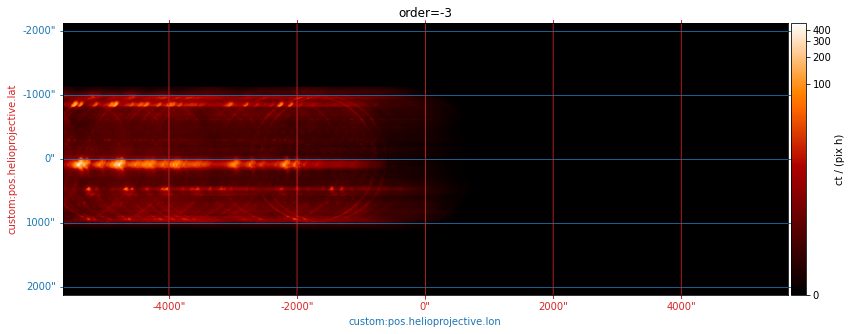

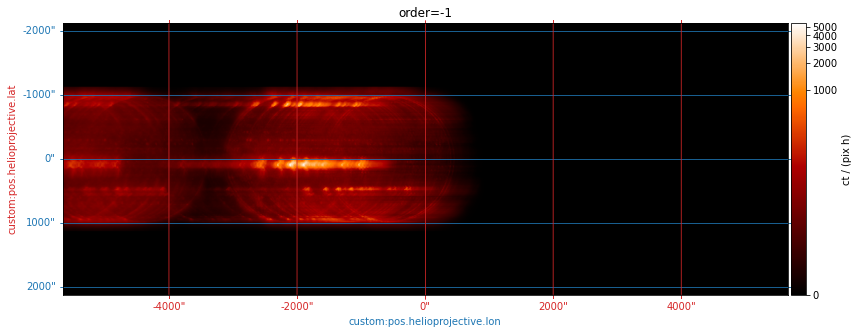

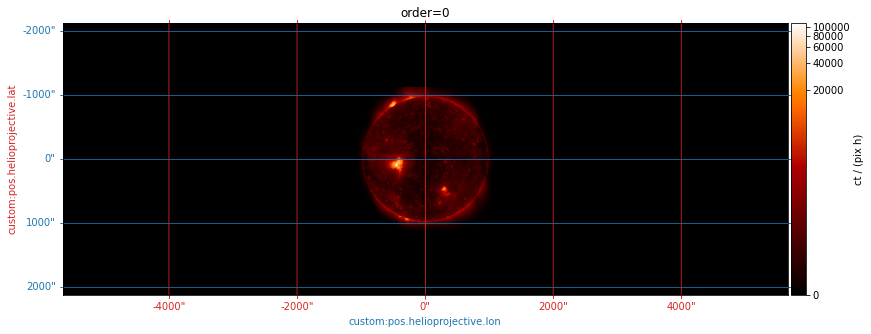

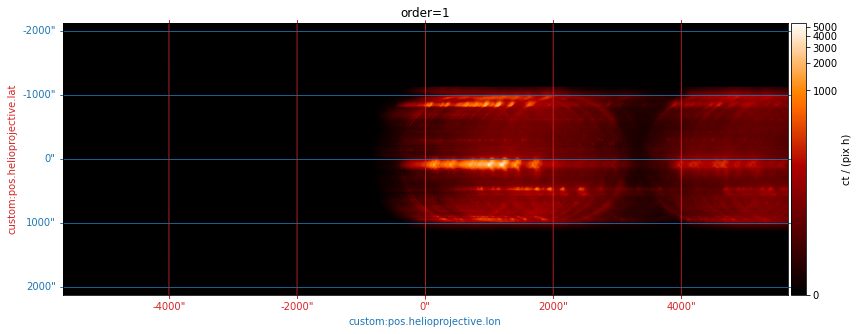

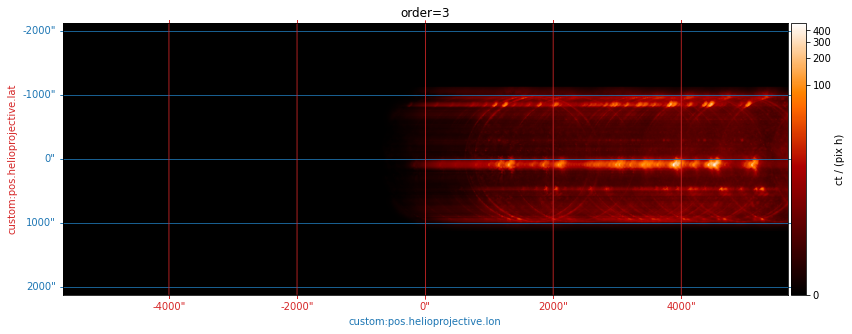

In [160]:
wave_index = 0
for k,_ocube in overlappograms.items():
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111, projection=_ocube[wave_index].wcs)
    plot_unit = 'ct / (pix h)'
    vmin, vmax = AsymmetricPercentileInterval(1,99.5).get_limits(
        u.Quantity(_ocube[wave_index].data, _ocube.unit).to_value(plot_unit),
    )
    _ocube[wave_index].plot(
        axes=ax,
        cmap='hinodexrt',
        norm=ImageNormalize(stretch=LogStretch()),
        data_unit=plot_unit
    )
    im = ax.get_images()[0]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cax.yaxis.set_ticks_position("right")
    cbar.set_label(f'{plot_unit}',)
    color_lat_lon_axes(ax)
    ax.set_title(f'order={k}')
    fig.savefig(f'output/overlappogram-active-region-order={k}-log.png',dpi=200)
#ax.set_title(f"{overlap_test.axis_world_coords(0)[1][0].to('Angstrom'):.02f}")

In [15]:
total_overlap_order1 = get_full_overlappogram(overlappograms, 1)

In [14]:
_spec_cube = convolve_with_response(spectral_cube, SpectrogramChannel(1, 'data/MOXSI_effarea.genx'))
wavelength = _spec_cube.axis_world_coords(0)[0]

/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/astropy/io/fits/card.py:264: VerifyWarning: Keyword name 'channel_name' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(


In [156]:
endpoints = SkyCoord(Tx=([100,100]*u.arcsec).to('deg'),
                     Ty=([-5600,5600]*u.arcsec).to('deg'),
                     frame=astropy.wcs.utils.wcs_to_celestial_frame(total_overlap_order1.wcs))

/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/astropy/wcs/wcsapi/fitswcs.py:597: AstropyUserWarning: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change
  warnings.warn(f'{msg}, SpectralCoord '


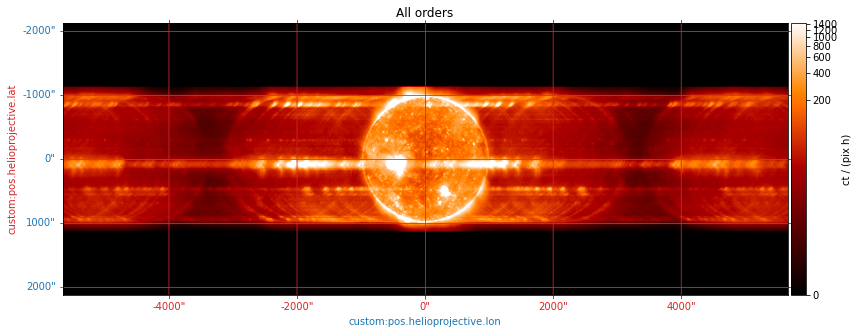

In [164]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, projection=total_overlap_order1[wave_index].wcs)
plot_unit = 'ct / (pix h)'
vmin, vmax = AsymmetricPercentileInterval(1,99.5).get_limits(
    u.Quantity(total_overlap_order1[wave_index].data, total_overlap_order1.unit).to_value(plot_unit),
)
total_overlap_order1[wave_index].plot(
    axes=ax,
    cmap='hinodexrt',
    norm=ImageNormalize(vmin=vmin,vmax=vmax,stretch=LogStretch()),
    data_unit=plot_unit
)
pix_x,pix_y,_ = total_overlap_order1.wcs.world_to_pixel(endpoints, wavelength[wave_index])
#ax.plot(pix_x, pix_y, ls='--', color='C1')
im = ax.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05, axes_class=matplotlib.axes.Axes)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cax.yaxis.set_ticks_position("right")
cbar.set_label(f'{plot_unit}',)
color_lat_lon_axes(ax)
ax.set_title(f'All orders')
fig.savefig(f'output/overlappogram-active-region-all-orders-log.png',dpi=200)

Overplot the zeroth order component to show what the spectrally pure case looks like

Better yet: choose a spatial coordinate and extract intensity along that for each order and the combined spectra.

In [150]:
def extract_along_coord_modified(smap, coord, wavelength):
    # Find pixels between each loop segment
    pz, px, py = smap.wcs.world_to_array_index(coord, wavelength)
    pix = []
    for i in range(len(px)-1):
        b = sunpy.map.maputils._bresenham(x1=px[i], y1=py[i], x2=px[i+1], y2=py[i+1])
        # Pop the last one, unless this is the final entry because the first point
        # of the next section will be the same
        if i < (len(px) - 2):
            b = b[:-1]
        pix.append(b)
    pix = np.vstack(pix)
        
    pix_z = np.array(pix.shape[0]*[pz[0]])

    intensity = u.Quantity(smap.data[pix_z, pix[:, 0], pix[:, 1]], smap.unit)
    coord_new,_ = smap.wcs.pixel_to_world(pix[:, 1], pix[:, 0], pix_z)

    return intensity, coord_new


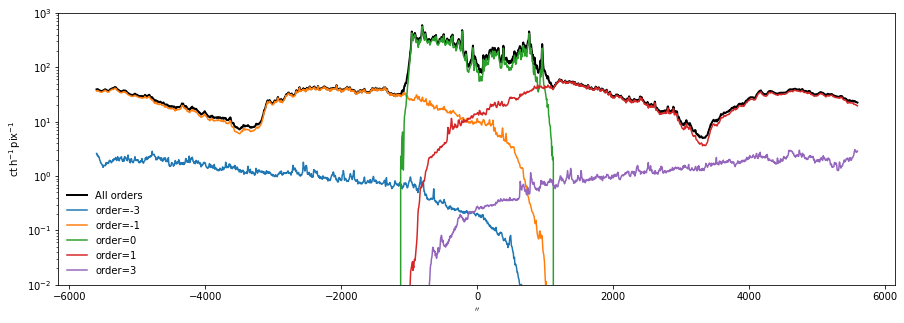

In [155]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
with quantity_support():
    # Combined
    intensity,intensity_coord = extract_along_coord_modified(total_overlap_order1, endpoints, wavelength[0])
    sep = intensity_coord.separation(intensity_coord[0])
    sep -= sep[sep.shape[0]//2]
    ax.plot(sep.to('arcsec'), intensity.to('ct pix-1 h-1'),color='k',lw=2,label='All orders')
    # other orders
    for k,cube in overlappograms.items():
        intensity,intensity_coord = extract_along_coord_modified(cube, endpoints, wavelength[0])
        sep = intensity_coord.separation(intensity_coord[0])
        sep -= sep[sep.shape[0]//2]
        ax.plot(sep.to('arcsec'), intensity.to('ct pix-1 h-1'), label=f'order={k}')
ax.set_yscale('log')
ax.set_ylim(1e-2,1e3)
ax.legend(frameon=False)
fig.savefig('output/intensity-cut-qs.png', dpi=200)

In [102]:
chan = SpectrogramChannel(1, 'data/MOXSI_effarea.genx')

In [105]:
chan._data

MetaDict([('channel', 'MOXSI_S1'),
          ('pix_size', 5.599999904632568),
          ('wave',
           array([ 1.   ,  1.055,  1.11 , ..., 59.85 , 59.905, 59.96 ], dtype=float32)),
          ('effarea',
           array([5.4786266e-08, 7.2209275e-08, 1.0308333e-07, ..., 1.2354516e-07,
                  1.2282830e-07, 1.2211430e-07], dtype=float32)),
          ('geo_area', 1.5205308045551647e-05),
          ('filter',
           array([0.99965   , 0.99958473, 0.99951947, ..., 0.20521599, 0.20453744,
                  0.20386156], dtype=float32)),
          ('filter_desc',
           '100 nm of Al based on conversation with Amir 11/11/20'),
          ('grating',
           array([0.03210442, 0.03424337, 0.04105496, ..., 0.03959308, 0.03949394,
                  0.03939453], dtype=float32)),
          ('grating_desc',
           'first order transmission of grating * polyimide, 11/11/20'),
          ('det',
           array([0.11227   , 0.13873997, 0.16521001, ..., 1.        , 1.    

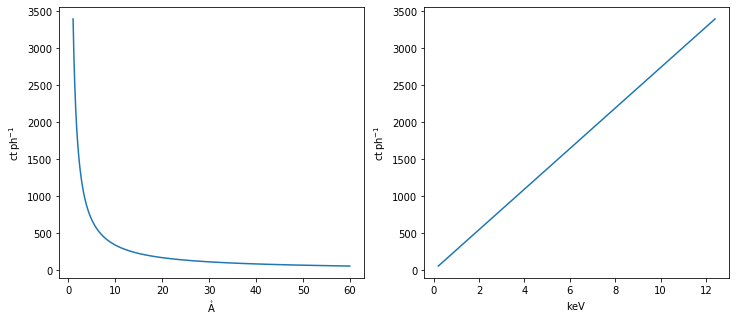

In [131]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
with quantity_support():
    ax.plot(chan.wavelength, chan.gain)
ax = fig.add_subplot(122)
photon_energy = astropy.constants.h * astropy.constants.c / chan.wavelength
with quantity_support():
    ax.plot(photon_energy.to('keV'), chan.gain)
plt.savefig('output/electron-to-photon-conversion.png', dpi=200)

## Sandbox

In [ ]:
def project_to_detector(cube, order, observer=None, ref_wave=None, ref_wave_pix=1, reproject_kwargs=None):
    if observer is None:
        # This does not always work in cases where the WCS is not a FITS WCS
        observer = astropy.wcs.utils.wcs_to_celestial_frame(cube.wcs).observer
    if ref_wave is None:
        ref_wave = cube.axis_world_coords(0)[0][0]
    # FIXME: need to pass dispersion_axis argument through to this function; the default is fine here
    return reproject_to_overlappogram(cube,
                                      DETECTOR_SHAPE_DISPERSED,
                                      scale=(CDELT_SPACE, CDELT_SPACE, CDELT_WAVE),
                                      reference_coord=(0*u.arcsec, 0*u.arcsec, ref_wave),
                                      reference_pixel=(
                                          (DETECTOR_SHAPE_DISPERSED[1] + 1)/2,
                                          (DETECTOR_SHAPE_DISPERSED[0] + 1)/2,
                                          ref_wave_pix,
                                      ) * u.pix,
                                      roll_angle=-90*u.deg,  # orient such that solar-N points along the +1 dispersed direction
                                      dispersion_angle=0*u.deg,
                                      order=order,
                                      observer=observer,
                                      sum_over_lambda=True,
                                      reproject_kwargs=reproject_kwargs)

In [ ]:
wave = spectral_cube.axis_world_coords(0)[0]

In [ ]:
def jax_map_coordinates_wrapper(*args, **kwargs):
    output = jax.scipy.ndimage.map_coordinates(*args, **kwargs)
    output = np.array(jax.device_get(output))
    return output

In [ ]:
%%snakeviz
i_select = 300
overlap_p1 = project_to_detector(
    #convolve_with_response(spectral_cube, SpectrogramChannel(order, 'data/MOXSI_effarea.genx'))[i_select:i_select+1,:,:],
    #spectral_cube_instr_jax[:5,:,:],
    spectral_cube_instr[:10,:,:],
    order,
    observer=observer,
    #ref_wave=wave[0],
    #ref_wave_pix=-i_select+1,
    reproject_kwargs={
    #    'map_coords_func': jax_map_coordinates_wrapper,
        'roundtrip_coords': False,
    },
)

In [16]:
foo = overlappogram_fits_wcs(
    DETECTOR_SHAPE_DISPERSED,
    spectral_cube.axis_world_coords(0)[0],
    (1*u.arcsec/u.pix, 1*u.arcsec/u.pix, 55*u.milliAA/u.pix),
    reference_pixel=(1000.5, 375.5, 1)*u.pix,
    reference_coord=(0*u.arcsec, 0*u.arcsec, 1*u.angstrom),
    pc_matrix=pcij_matrix(-90*u.deg, 0*u.deg, 1),
    observer=observer,
)

In [19]:
foo.wcs.reference_pixel

AttributeError: 'astropy.wcs.Wcsprm' object has no attribute 'reference_pixel'

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7f7268abeca0>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7f7268ac8ca0>)

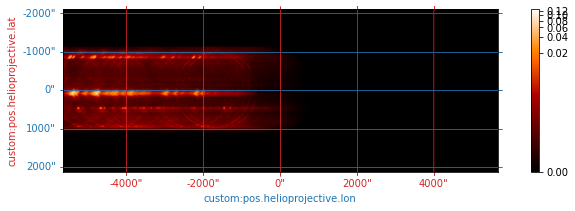

In [15]:
wave_index = 0
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111, projection=overlappograms[0][wave_index].wcs)
overlappograms[0][wave_index].plot(axes=ax, cmap='hinodexrt', norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()
color_lat_lon_axes(ax)
#ax.set_title(f"{overlap_test.axis_world_coords(0)[1][0].to('Angstrom'):.02f}")

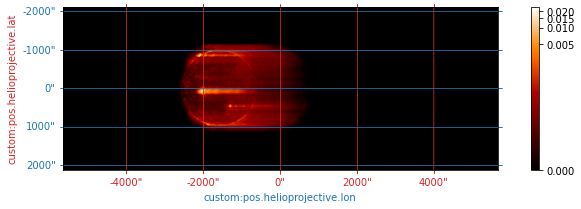

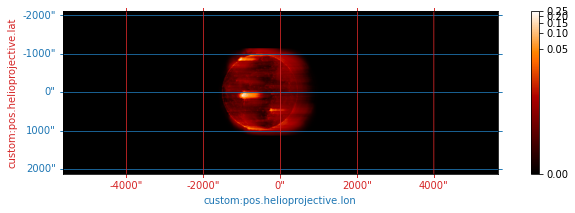

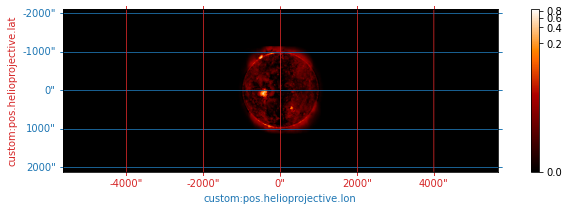

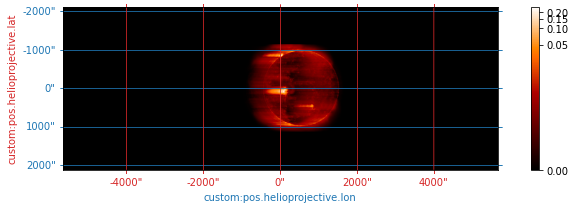

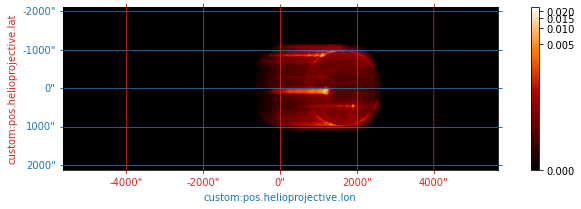

In [29]:
wave_index = 0
for _ocube in overlappograms:
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111, projection=_ocube[wave_index].wcs)
    _ocube[wave_index].plot(axes=ax, cmap='hinodexrt', norm=ImageNormalize(stretch=LogStretch()))
    plt.colorbar()
    color_lat_lon_axes(ax)
#ax.set_title(f"{overlap_test.axis_world_coords(0)[1][0].to('Angstrom'):.02f}")

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7f9140f07700>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7f914a037e80>)

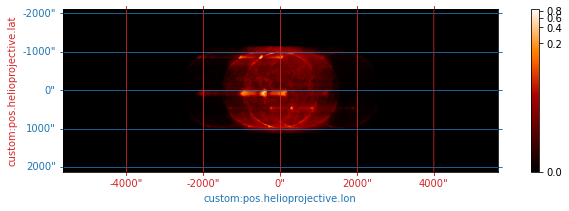

In [28]:
wave_index = 0
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111, projection=total_order1[wave_index].wcs)
total_order1[wave_index].plot(axes=ax, cmap='hinodexrt', norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()
color_lat_lon_axes(ax)
#ax.set_title(f"{overlap_test.axis_world_coords(0)[1][0].to('Angstrom'):.02f}")